<a href="https://colab.research.google.com/github/YongjaeKwon0629/07_07_OpenCV/blob/main/07_07_ML_EX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 주요 라이브러리 임포트
import tensorflow as tf  # 딥러닝 모델 구축용
from tensorflow.keras import layers, models  # CNN 등 레이어 구성용
from sklearn.model_selection import train_test_split  # 데이터 분할
from sklearn.ensemble import RandomForestClassifier  # 차선 분류용 머신러닝 모델
from sklearn.metrics import accuracy_score, classification_report  # 성능 평가
import matplotlib.pyplot as plt  # (현재 미사용) 시각화 도구
import os  # 파일 경로 확인용
from PIL import Image  # (현재 미사용) 이미지 처리용
import numpy as np  # 수치 계산용
import cv2  # OpenCV: 이미지 처리용 (주의: 꼭 설치 필요)

# 자율주행 시스템 클래스 정의
class AutonomousDrivingMLSystem:
    def __init__(self):
        # 차선 탐지, 교통표지판 분류기, 속도 예측기 (현재 속도 예측은 미사용)
        self.lane_detector = None
        self.traffic_sign_classifier = None
        self.speed_predictor = None

    def preprocess_image(self, image_path):
        """이미지를 로드하고 크기 조정 및 정규화 수행"""
        image = cv2.imread(image_path)  # 이미지 불러오기
        if image is None:
            return None

        image = cv2.resize(image, (224, 224))  # 고정 크기로 조정
        image = image.astype(np.float32) / 255.0  # 0~1 사이 정규화
        return image

    def detect_lane_features(self, image):
        """차선에서 특징(기울기, 길이, 좌표 등) 추출"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # 흑백 변환
        blur = cv2.GaussianBlur(gray, (5, 5), 0)  # 노이즈 제거
        edges = cv2.Canny(blur, 50, 150)  # 엣지(경계) 검출

        # ROI 설정: 하단 절반만 사용
        height = edges.shape[0]
        mask = np.zeros_like(edges)
        polygon = np.array([[
            (0, height),
            (edges.shape[1], height),
            (edges.shape[1], height//2),
            (0, height//2)
        ]], np.int32)
        cv2.fillPoly(mask, polygon, 255)  # 마스크에 폴리곤 영역 표시
        masked_edges = cv2.bitwise_and(edges, mask)  # ROI 외 영역 제거

        # 허프 변환으로 직선 검출
        lines = cv2.HoughLinesP(masked_edges, 1, np.pi/180,
                               threshold=50, minLineLength=100, maxLineGap=50)

        features = []
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                if x2 - x1 != 0:
                    slope = (y2 - y1) / (x2 - x1)  # 기울기 계산
                    length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)  # 선 길이
                    features.extend([slope, length, x1, y1, x2, y2])  # 특징 저장

        # 부족한 특징은 0으로 채워서 고정 길이 (30개) 유지
        while len(features) < 30:
            features.append(0)
        return features[:30]  # 최대 30개 반환

    def build_traffic_sign_cnn(self):
        """교통 표지판 인식을 위한 간단한 CNN 모델 구성"""
        model = models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.5),  # 과적합 방지용
            layers.Dense(4, activation='softmax')  # 클래스: 정지, 직진, 좌회전, 우회전
        ])
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])  # 정수 레이블이므로 sparse 사용
        return model

    def generate_sample_data(self):
        """샘플용 난수 기반 데이터 생성 (실제 데이터 아님)"""
        np.random.seed(42)
        lane_features = []
        lane_decisions = []

        # 차선 데이터: 1000개 생성
        for i in range(1000):
            features = np.random.randn(30)  # 30개 난수 특징
            if features[0] < -0.5:
                decision = 0  # 좌회전
            elif features[0] > 0.5:
                decision = 2  # 우회전
            else:
                decision = 1  # 직진
            lane_features.append(features)
            lane_decisions.append(decision)

        # 교통 표지판 이미지 데이터 (랜덤)
        sign_images = np.random.rand(500, 64, 64, 3)
        sign_labels = np.random.randint(0, 4, 500)  # 0~3 정수 라벨

        return np.array(lane_features), np.array(lane_decisions), sign_images, sign_labels

    def train_lane_keeping_system(self):
        """차선 유지 시스템 모델 학습 및 평가"""
        print("차선 유지 시스템 훈련 시작...")
        lane_features, lane_decisions, _, _ = self.generate_sample_data()

        # 데이터 분할
        X_train, X_test, y_train, y_test = train_test_split(
            lane_features, lane_decisions, test_size=0.2, random_state=42
        )

        # Random Forest 훈련
        self.lane_detector = RandomForestClassifier(n_estimators=100, random_state=42)
        self.lane_detector.fit(X_train, y_train)

        # 성능 평가
        y_pred = self.lane_detector.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"차선 유지 시스템 정확도: {accuracy:.3f}")
        print("\n분류 보고서:")
        print(classification_report(y_test, y_pred,
                                    target_names=['좌회전', '직진', '우회전']))
        return accuracy

    def train_traffic_sign_classifier(self):
        """교통 표지판 분류용 CNN 학습"""
        print("\n교통 표지판 분류기 훈련 시작...")
        _, _, sign_images, sign_labels = self.generate_sample_data()

        # 데이터 분할
        X_train, X_test, y_train, y_test = train_test_split(
            sign_images, sign_labels, test_size=0.2, random_state=42
        )

        # CNN 생성 및 훈련
        self.traffic_sign_classifier = self.build_traffic_sign_cnn()
        history = self.traffic_sign_classifier.fit(
            X_train, y_train,
            epochs=10,
            batch_size=32,
            validation_data=(X_test, y_test),
            verbose=1
        )

        # 성능 평가
        test_loss, test_accuracy = self.traffic_sign_classifier.evaluate(X_test, y_test, verbose=0)
        print(f"\n교통 표지판 분류 정확도: {test_accuracy:.3f}")
        return test_accuracy

    def predict_driving_action(self, image_path):
        """입력 이미지 기반 주행 행동 예측"""
        if not os.path.exists(image_path):
            print("이미지 파일을 찾을 수 없습니다.")
            return None

        image = self.preprocess_image(image_path)  # 전처리 수행
        if image is None:
            print("이미지 로딩 실패")
            return None

        # 차선 특징 추출
        lane_features = self.detect_lane_features((image * 255).astype(np.uint8))

        # 차선 기반 주행 판단
        if self.lane_detector:
            lane_decision = self.lane_detector.predict([lane_features])[0]
            lane_actions = ['좌회전', '직진', '우회전']
            print(f"차선 분석 결과: {lane_actions[lane_decision]}")

        # 교통표지판 예측
        if self.traffic_sign_classifier:
            sign_image = cv2.resize((image * 255).astype(np.uint8), (64, 64))
            sign_image = np.expand_dims(sign_image.astype(np.float32) / 255.0, axis=0)
            sign_prediction = self.traffic_sign_classifier.predict(sign_image, verbose=0)
            sign_class = np.argmax(sign_prediction[0])
            sign_confidence = np.max(sign_prediction[0])
            sign_names = ['정지', '직진', '좌회전', '우회전']
            print(f"교통표지판 인식: {sign_names[sign_class]} (신뢰도: {sign_confidence:.3f})")

        return lane_decision if self.lane_detector else None

# 전체 시스템 실행 메인 함수
def main():
    """자율주행 지도학습 시스템 전체 실행"""
    print("=== 자율주행 지도학습 시스템 ===\n")

    # 시스템 객체 생성
    autonomous_system = AutonomousDrivingMLSystem()

    # 모델 학습 수행
    lane_accuracy = autonomous_system.train_lane_keeping_system()
    sign_accuracy = autonomous_system.train_traffic_sign_classifier()

    # 훈련 결과 출력
    print(f"\n=== 훈련 완료 ===")
    print(f"차선 유지 시스템 정확도: {lane_accuracy:.1%}")
    print(f"교통표지판 분류 정확도: {sign_accuracy:.1%}")

    # 테스트 이미지 사용 시 예측 실행
    # test_image = "sample_road.jpg"
    # result = autonomous_system.predict_driving_action(test_image)

# 프로그램 진입점
if __name__ == "__main__":
    main()


=== 자율주행 지도학습 시스템 ===

차선 유지 시스템 훈련 시작...
차선 유지 시스템 정확도: 1.000

분류 보고서:
              precision    recall  f1-score   support

         좌회전       1.00      1.00      1.00        69
          직진       1.00      1.00      1.00        72
         우회전       1.00      1.00      1.00        59

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200


교통 표지판 분류기 훈련 시작...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 240ms/step - accuracy: 0.2544 - loss: 1.4288 - val_accuracy: 0.2300 - val_loss: 1.3863
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.2706 - loss: 1.3871 - val_accuracy: 0.2800 - val_loss: 1.3869
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2505 - loss: 1.3891 - val_accuracy: 0.2200 - val_loss: 1.3886
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2850 - loss: 1.3845 - val_accuracy: 0.1500 - val_loss: 1.3879
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2306 - loss: 1.3903 - val_accuracy: 0.2200 - val_loss: 1.3915
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2377 - loss: 1.3821 - val_accuracy: 0.2200 - val_loss: 1.3957
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3075 - loss: 1.3798 - val_accuracy: 0.2400 - val_loss: 1.3867
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2750 - loss: 1.3839 - val_accuracy: 0.2200 -

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (6,043 kB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 126308 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr

Saving vywlvks.webp to vywlvks.webp

🔍 'vywlvks.webp' 분석 중...


/tmp/ipython-input-3-375936372.py:298: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()



🎯 분석 결과: guide_sign
🎨 검출된 색상: blue (70.6%)
📐 검출된 모양: rectangle_guide_sign
🔍 Debug: 'guide_sign' → 'Guide Sign'


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


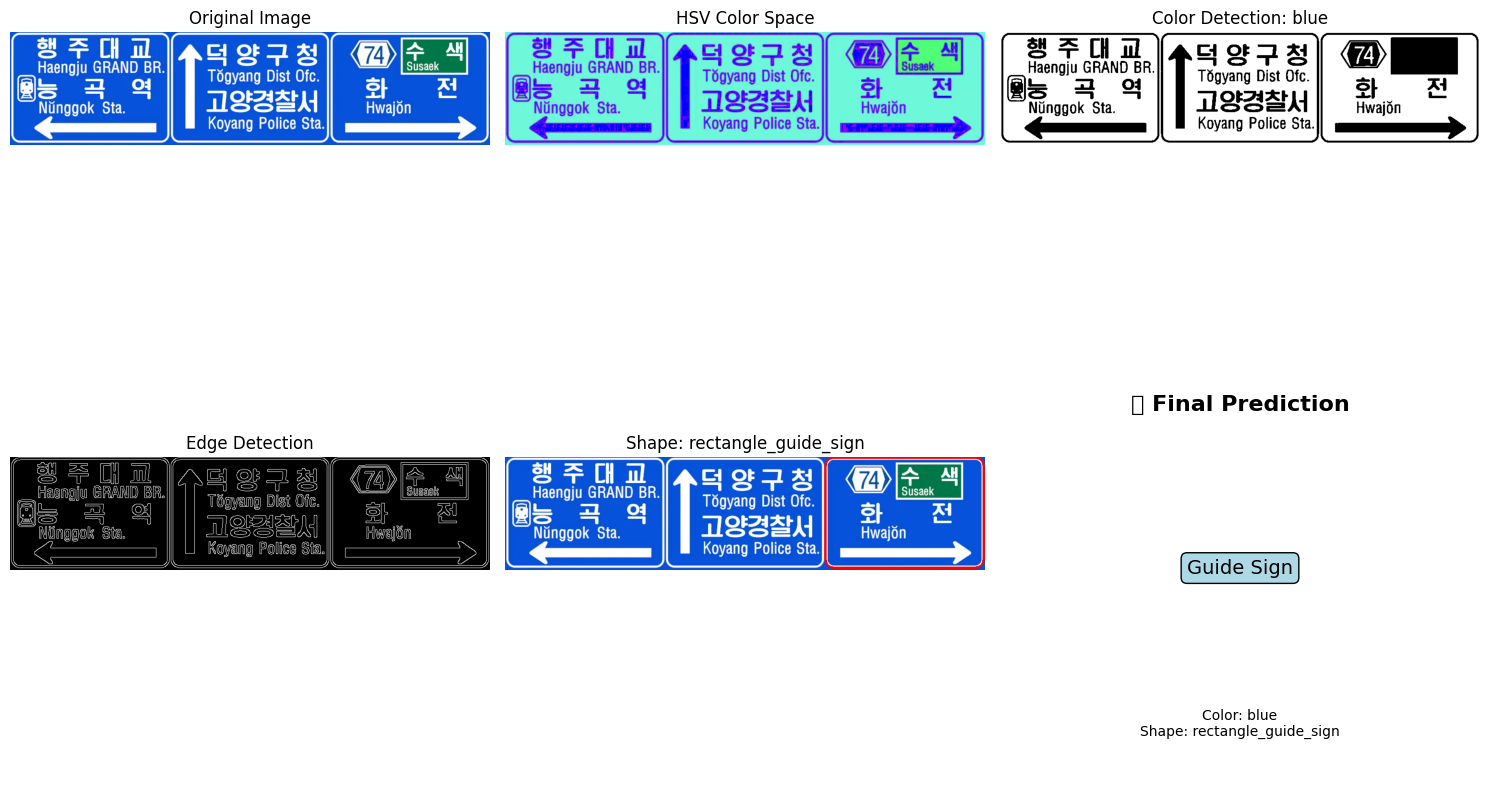

--------------------------------------------------

🔄 다른 이미지도 분석하시겠어요? (y/n): y
📷 교통표지판 이미지를 업로드해주세요!


/tmp/ipython-input-3-375936372.py:298: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


Saving 표지판 종합.png to 표지판 종합.png

🔍 '표지판 종합.png' 분석 중...

🎯 분석 결과: stop_sign
🎨 검출된 색상: red (10.3%)
📐 검출된 모양: octagon_stop_sign
📝 텍스트 정보: ['text_included_stop_possible']
🔍 Debug: 'stop_sign' → 'STOP Sign'


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


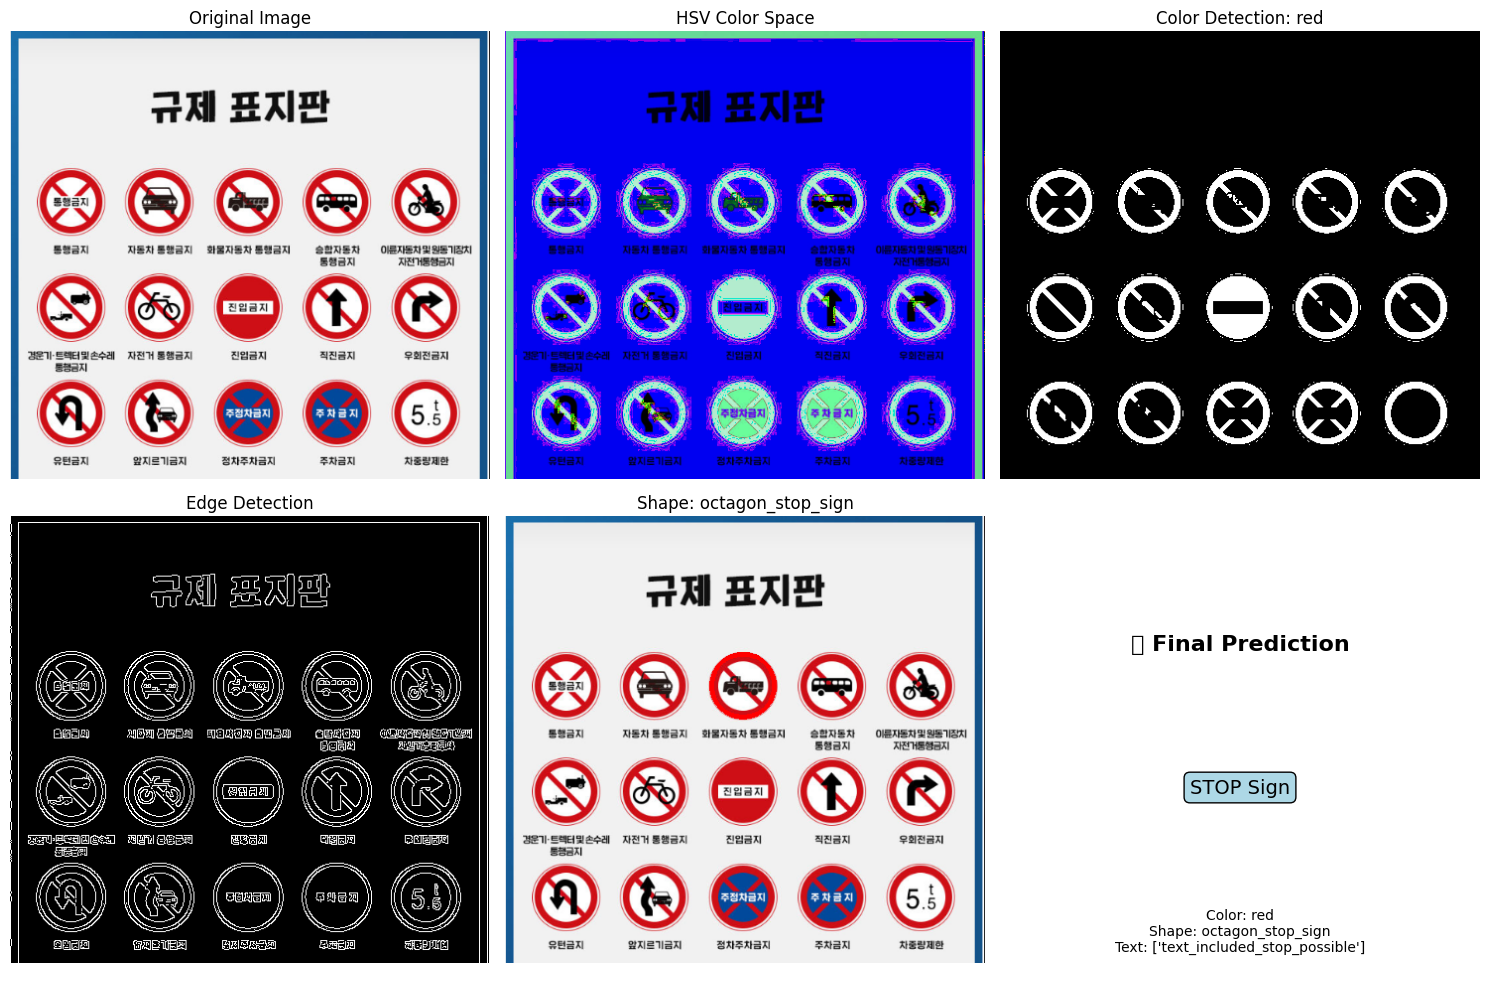

--------------------------------------------------

🔄 다른 이미지도 분석하시겠어요? (y/n): n

🎉 OpenCV 교통표지판 인식 완료!


In [3]:
# OpenCV 교통표지판 인식 (훈련 불필요!)


!pip install opencv-python matplotlib pillow
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import io
from PIL import Image

# 한글 폰트 설정 (Colab용)
import matplotlib.font_manager as fm

# Colab에서 한글 폰트 설치
!apt-get install -y fonts-nanum
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False
class OpenCVTrafficSignRecognizer:
    def __init__(self):
        # 색상 범위 정의 (HSV 색공간)
        self.color_ranges = {
            'red': {
                'lower1': np.array([0, 120, 70]),    # 빨간색 범위1
                'upper1': np.array([10, 255, 255]),
                'lower2': np.array([170, 120, 70]),  # 빨간색 범위2
                'upper2': np.array([180, 255, 255]),
                'sign_type': 'stop_prohibition'
            },
            'blue': {
                'lower': np.array([90, 100, 50]),    # 파란색
                'upper': np.array([150, 255, 255]),
                'sign_type': 'direction_guide'
            },
            'yellow': {
                'lower': np.array([15, 150, 150]),   # 노란색
                'upper': np.array([35, 255, 255]),
                'sign_type': 'warning_caution'
            },
            'green': {
                'lower': np.array([40, 150, 100]),   # 초록색
                'upper': np.array([80, 255, 255]),
                'sign_type': 'safety_permission'
            }
        }
    def detect_color(self, image):
        """색상 기반 표지판 분류"""
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

        detected_colors = []

        for color_name, color_info in self.color_ranges.items():
            if color_name == 'red':
                # 빨간색은 HSV에서 두 범위로 나뉨
                mask1 = cv2.inRange(hsv, color_info['lower1'], color_info['upper1'])
                mask2 = cv2.inRange(hsv, color_info['lower2'], color_info['upper2'])
                mask = cv2.bitwise_or(mask1, mask2)
            else:
                mask = cv2.inRange(hsv, color_info['lower'], color_info['upper'])

            # 색상 픽셀 수 계산
            color_pixels = cv2.countNonZero(mask)
            total_pixels = image.shape[0] * image.shape[1]
            color_ratio = color_pixels / total_pixels

            if color_ratio > 0.1:  # 10% 이상이면 해당 색상으로 판정
                detected_colors.append({
                    'color': color_name,
                    'ratio': color_ratio,
                    'sign_type': color_info['sign_type'],
                    'mask': mask
                })
                 # 가장 많은 색상 반환
        if detected_colors:
            return max(detected_colors, key=lambda x: x['ratio'])
        return None

    def detect_shapes(self, image):
        """모양 기반 표지판 분류"""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # 가우시안 블러 적용
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)

        # 에지 검출
        edges = cv2.Canny(blurred, 50, 150)

        # 컨투어 찾기
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        shapes = []
        for contour in contours:
            # 작은 컨투어 무시
            if cv2.contourArea(contour) < 500:
                continue

            # 컨투어 근사화
            epsilon = 0.02 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)

            # 꼭짓점 수로 모양 판별
            vertices = len(approx)

            # 모양 분류
            if vertices == 3:
                shape_type = "triangle_warning_sign"
            elif vertices == 4:
                # 사각형인지 확인
                x, y, w, h = cv2.boundingRect(approx)
                aspect_ratio = w / float(h)
                if 0.95 <= aspect_ratio <= 1.05:
                    shape_type = "square_general_sign"
                else:
                    shape_type = "rectangle_guide_sign"
            elif 5 <= vertices <= 10:
                shape_type = "octagon_stop_sign"
            else:
                # 원형 여부 확인
                area = cv2.contourArea(contour)
                perimeter = cv2.arcLength(contour, True)
                if perimeter > 0:
                    circularity = 4 * np.pi * area / (perimeter * perimeter)
                    if circularity > 0.7:
                        shape_type = "circle_direction_sign"
                    else:
                        shape_type = "other_shape"
                else:
                    shape_type = "other_shape"
            shapes.append({
                'shape': shape_type,
                'vertices': vertices,
                'area': cv2.contourArea(contour),
                'contour': contour
            })

        # 가장 큰 모양 반환
        if shapes:
            return max(shapes, key=lambda x: x['area'])
        return None

    def detect_text_patterns(self, image):
        """텍스트 패턴 인식 (간단한 템플릿 매칭)"""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # 이진화
        _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)
        # STOP 텍스트 특징 검사 (간단한 방법)
        # 중앙 영역의 백색 픽셀 패턴 확인
        h, w = binary.shape
        center_region = binary[h//3:2*h//3, w//4:3*w//4]
        white_pixels = cv2.countNonZero(center_region)
        total_pixels = center_region.shape[0] * center_region.shape[1]

        text_patterns = []

        if white_pixels / total_pixels > 0.3:  # 30% 이상 흰 픽셀
            text_patterns.append("text_included_stop_possible")

        return text_patterns

    def classify_traffic_sign(self, image):
        """종합적인 교통표지판 분류"""
        # 1. 색상 검출
        color_result = self.detect_color(image)

        # 2. 모양 검출
        shape_result = self.detect_shapes(image)

        # 3. 텍스트 패턴 검출
        text_result = self.detect_text_patterns(image)

        # 4. 종합 판단
        classification = {
            'color_info': color_result,
            'shape_info': shape_result,
            'text_info': text_result,
            'final_prediction': 'unknown_sign'
        }
        # 규칙 기반 분류
        if color_result and shape_result:
            color = color_result['color']
            shape = shape_result['shape']

            if color == 'red':
                if 'octagon' in shape or 'text_included' in str(text_result):
                    classification['final_prediction'] = 'stop_sign'
                else:
                    classification['final_prediction'] = 'prohibition_sign'
            elif color == 'blue':
                if 'circle' in shape:
                    classification['final_prediction'] = 'direction_sign'
                else:
                    classification['final_prediction'] = 'guide_sign'
            elif color == 'yellow':
                if 'triangle' in shape:
                    classification['final_prediction'] = 'warning_sign'
                else:
                    classification['final_prediction'] = 'caution_sign'
            elif color == 'green':
                classification['final_prediction'] = 'safety_sign'

        elif color_result:
            # 색상만으로 판단
            if color_result['sign_type'] == 'stop_prohibition':
                classification['final_prediction'] = 'stop_sign'
            elif color_result['sign_type'] == 'direction_guide':
                classification['final_prediction'] = 'direction_sign'
            elif color_result['sign_type'] == 'warning_caution':
                classification['final_prediction'] = 'warning_sign'
            elif color_result['sign_type'] == 'safety_permission':
                classification['final_prediction'] = 'safety_sign'
            else:
                classification['final_prediction'] = color_result['sign_type']

        elif shape_result:
            # 모양만으로 판단
            if 'octagon' in shape_result['shape']:
                classification['final_prediction'] = 'stop_sign_by_shape'
            elif 'triangle' in shape_result['shape']:
                classification['final_prediction'] = 'warning_sign_by_shape'
            elif 'circle' in shape_result['shape']:
                classification['final_prediction'] = 'direction_sign_by_shape'

        return classification
    def visualize_detection(self, image, classification):
        """검출 결과 시각화"""
        plt.figure(figsize=(15, 10))

        # 1. 원본 이미지
        plt.subplot(2, 3, 1)
        plt.imshow(image)
        plt.title('Original Image')
        plt.axis('off')

        # 2. HSV 이미지
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        plt.subplot(2, 3, 2)
        plt.imshow(hsv)
        plt.title('HSV Color Space')
        plt.axis('off')

        # 3. 색상 마스크
        plt.subplot(2, 3, 3)
        if classification['color_info']:
            plt.imshow(classification['color_info']['mask'], cmap='gray')
            plt.title(f"Color Detection: {classification['color_info']['color']}")
        else:
            plt.text(0.5, 0.5, 'Color Not Detected', ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('Color Detection Failed')
        plt.axis('off')
        # 4. 에지 검출
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        edges = cv2.Canny(gray, 50, 150)
        plt.subplot(2, 3, 4)
        plt.imshow(edges, cmap='gray')
        plt.title('Edge Detection')
        plt.axis('off')

        # 5. 모양 검출
        plt.subplot(2, 3, 5)
        shape_image = image.copy()
        if classification['shape_info']:
            cv2.drawContours(shape_image, [classification['shape_info']['contour']], -1, (255, 0, 0), 3)
            plt.imshow(shape_image)
            plt.title(f"Shape: {classification['shape_info']['shape']}")
        else:
            plt.imshow(image)
            plt.title('Shape Not Detected')
        plt.axis('off')

        # 6. 최종 결과
        plt.subplot(2, 3, 6)
        plt.text(0.5, 0.7, '🎯 Final Prediction', ha='center', va='center',
                transform=plt.gca().transAxes, fontsize=16, fontweight='bold')

        # 영어 예측 결과를 읽기 쉬운 영어로 변환해서 표시
        prediction_english = self.convert_prediction_to_english(classification['final_prediction'])
        plt.text(0.5, 0.4, prediction_english, ha='center', va='center',
                transform=plt.gca().transAxes, fontsize=14,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
        # 상세 정보 (영어로)
        details = ""
        if classification['color_info']:
            details += f"Color: {classification['color_info']['color']}\n"
        if classification['shape_info']:
            details += f"Shape: {classification['shape_info']['shape']}\n"
        if classification['text_info']:
            details += f"Text: {classification['text_info']}"

        plt.text(0.5, 0.1, details, ha='center', va='center',
                transform=plt.gca().transAxes, fontsize=10)
        plt.axis('off')

        plt.tight_layout()
        plt.show()
    def convert_prediction_to_english(self, prediction):
        """영어 예측 결과를 더 읽기 쉬운 영어로 변환"""
        conversion_dict = {
            'stop_sign': 'STOP Sign',
            'direction_sign': 'Direction Sign',
            'warning_sign': 'Warning Sign',
            'caution_sign': 'Caution Sign',
            'safety_sign': 'Safety Sign',
            'prohibition_sign': 'Prohibition Sign',
            'guide_sign': 'Guide Sign',
            'stop_sign_by_shape': 'STOP Sign (by shape)',
            'warning_sign_by_shape': 'Warning Sign (by shape)',
            'direction_sign_by_shape': 'Direction Sign (by shape)',
            'unknown_sign': 'Unknown Sign',
            'stop_prohibition': 'STOP/Prohibition Sign',
            'direction_guide': 'Direction/Guide Sign',
            'warning_caution': 'Warning/Caution Sign',
            'safety_permission': 'Safety/Permission Sign'
        }

        result = conversion_dict.get(prediction, f'Unclassified: {prediction}')
        print(f"🔍 Debug: '{prediction}' → '{result}'")
        return result
    def upload_and_analyze(self):
        """이미지 업로드 및 분석"""
        print("📷 교통표지판 이미지를 업로드해주세요!")
        print("=" * 50)

        uploaded = files.upload()

        if not uploaded:
            print("❌ 업로드된 파일이 없습니다.")
            return

        for filename, file_data in uploaded.items():
            print(f"\n🔍 '{filename}' 분석 중...")

            try:
                # 이미지 로드
                image = Image.open(io.BytesIO(file_data))
                if image.mode != 'RGB':
                    image = image.convert('RGB')

                image_array = np.array(image)

                # 분석 수행
                result = self.classify_traffic_sign(image_array)

                # 결과 출력
                print(f"\n🎯 분석 결과: {result['final_prediction']}")

                if result['color_info']:
                    print(f"🎨 검출된 색상: {result['color_info']['color']} ({result['color_info']['ratio']:.1%})")

                if result['shape_info']:
                    print(f"📐 검출된 모양: {result['shape_info']['shape']}")

                if result['text_info']:
                    print(f"📝 텍스트 정보: {result['text_info']}")
                    # 시각화
                self.visualize_detection(image_array, result)

                print("-" * 50)

            except Exception as e:
                print(f"❌ 오류 발생: {e}")

def main():
    """메인 실행 함수"""
    print("🚗 OpenCV 교통표지판 인식 시스템")
    print("=" * 50)
    print("🎯 특징: 훈련 불필요, 즉시 인식!")
    print("🔍 방법: 색상 + 모양 + 텍스트 패턴 분석")
    print("📊 인식 가능: 정지, 지시, 경고, 안내 표지판")
    print("=" * 50)

    # 시스템 초기화
    recognizer = OpenCVTrafficSignRecognizer()

    # 이미지 분석
    while True:
        recognizer.upload_and_analyze()

        continue_choice = input("\n🔄 다른 이미지도 분석하시겠어요? (y/n): ")
        if continue_choice.lower() != 'y':
            break

    print("\n🎉 OpenCV 교통표지판 인식 완료!")

if __name__ == "__main__":
    main()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (10.2 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 126308 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/

Saving 표지판예시.jpg to 표지판예시.jpg

🔍 '표지판예시.jpg' 분석 중...

🎯 분석 결과: unknown_sign
📐 모양: rectangle_guide_sign
📝 텍스트 정보: ['text_included_stop_possible']


/tmp/ipython-input-2-3632955953.py:249: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


🔍 Debug: 'unknown_sign' → 'Unknown Sign'


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


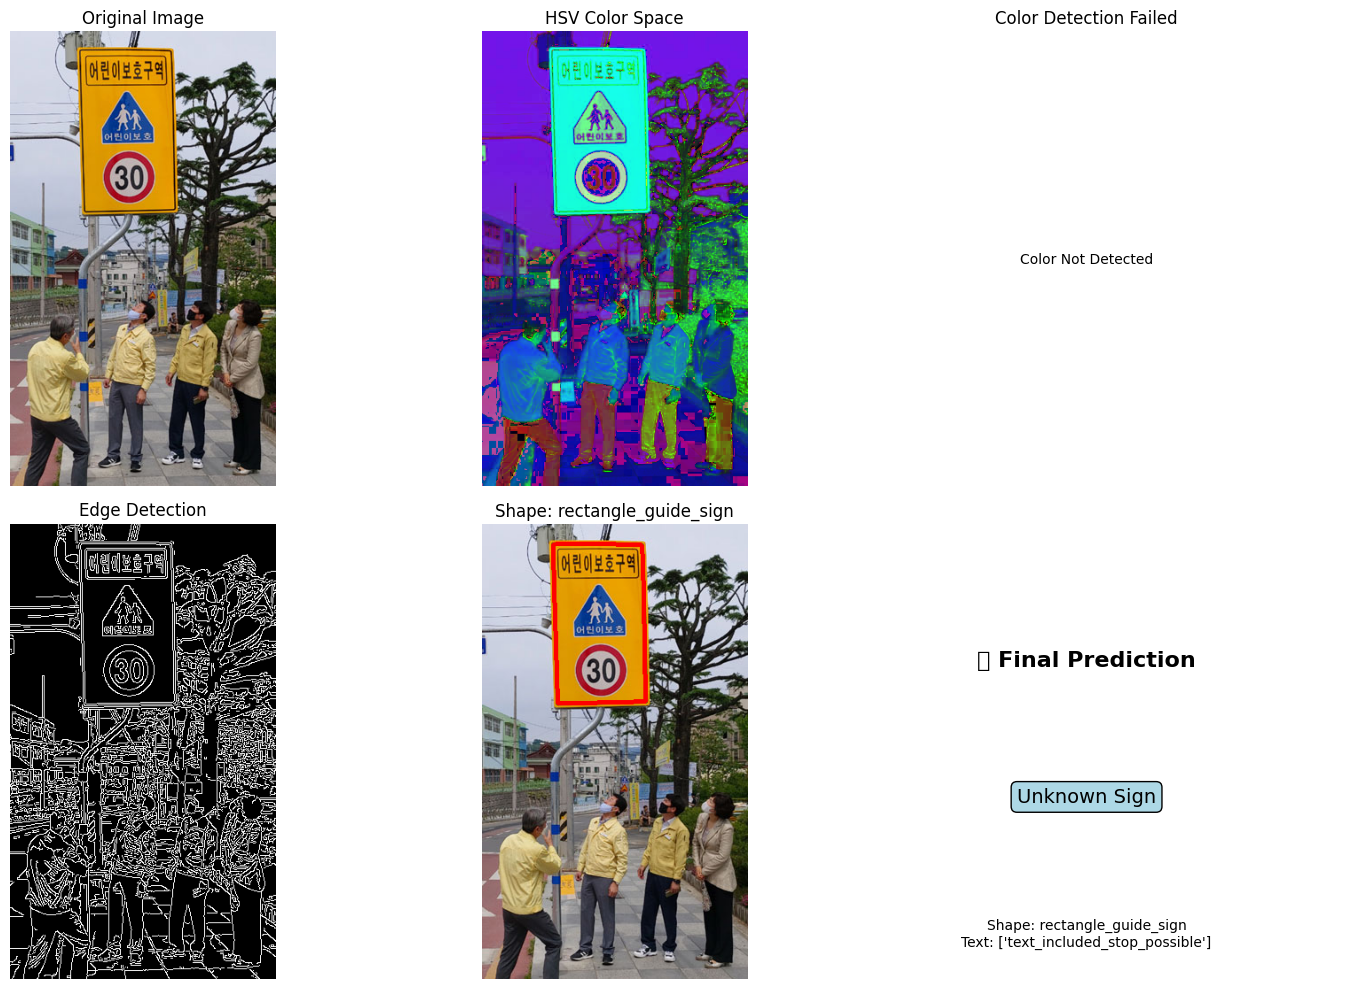

--------------------------------------------------

🔄 다른 이미지도 분석하시겠어요? (y/n): n

🎉 OpenCV 교통표지판 인식 완료!


In [2]:
# 🔧 필요한 패키지 설치 (Colab 환경 기준)
!pip install opencv-python matplotlib pillow

# 📦 라이브러리 불러오기
import cv2  # OpenCV: 이미지 처리용
import numpy as np  # 수치 계산용
import matplotlib.pyplot as plt  # 시각화용
from google.colab import files  # Colab에서 파일 업로드
import io  # 바이너리 파일 처리
from PIL import Image  # 이미지 열기 및 변환

# 📌 한글 폰트 설정 (시각화용)
import matplotlib.font_manager as fm

# ✅ 나눔 폰트 설치 (Colab 한글 깨짐 방지)
!apt-get install -y fonts-nanum
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 📊 Matplotlib 한글 적용
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# 🚘 OpenCV 기반 교통표지판 인식 클래스 정의
class OpenCVTrafficSignRecognizer:
    def __init__(self):
        # HSV 색상 범위 정의 (각 색상마다 신호 유형과 연결)
        self.color_ranges = {
            'red': {
                # 빨간색은 Hue가 양 끝에 걸쳐 있으므로 두 범위 지정
                'lower1': np.array([0, 120, 70]),
                'upper1': np.array([10, 255, 255]),
                'lower2': np.array([170, 120, 70]),
                'upper2': np.array([180, 255, 255]),
                'sign_type': 'stop_prohibition'  # 정지/금지
            },
            'blue': {
                'lower': np.array([90, 100, 50]),
                'upper': np.array([150, 255, 255]),
                'sign_type': 'direction_guide'  # 지시/안내
            },
            'yellow': {
                'lower': np.array([15, 150, 150]),
                'upper': np.array([35, 255, 255]),
                'sign_type': 'warning_caution'  # 경고
            },
            'green': {
                'lower': np.array([40, 150, 100]),
                'upper': np.array([80, 255, 255]),
                'sign_type': 'safety_permission'  # 안전
            }
        }

    def detect_color(self, image):
        """색상 기반으로 표지판 색 검출"""
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)  # RGB → HSV 변환

        detected_colors = []

        for color_name, color_info in self.color_ranges.items():
            if color_name == 'red':
                # 빨간색은 두 범위를 합쳐서 처리
                mask1 = cv2.inRange(hsv, color_info['lower1'], color_info['upper1'])
                mask2 = cv2.inRange(hsv, color_info['lower2'], color_info['upper2'])
                mask = cv2.bitwise_or(mask1, mask2)
            else:
                mask = cv2.inRange(hsv, color_info['lower'], color_info['upper'])

            # 마스크의 픽셀 수를 기반으로 비율 계산
            color_pixels = cv2.countNonZero(mask)
            total_pixels = image.shape[0] * image.shape[1]
            color_ratio = color_pixels / total_pixels

            if color_ratio > 0.1:  # 10% 이상일 경우 유의미하다고 판단
                detected_colors.append({
                    'color': color_name,
                    'ratio': color_ratio,
                    'sign_type': color_info['sign_type'],
                    'mask': mask
                })

        # 가장 많이 차지하는 색상 반환
        if detected_colors:
            return max(detected_colors, key=lambda x: x['ratio'])
        return None

    def detect_shapes(self, image):
        """모양(도형) 기반 표지판 분류"""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # 그레이스케일 변환
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)  # 노이즈 제거
        edges = cv2.Canny(blurred, 50, 150)  # 엣지 검출

        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        shapes = []
        for contour in contours:
            if cv2.contourArea(contour) < 500:
                continue  # 너무 작은 외곽선 무시

            # 꼭짓점 개수 파악을 위한 근사화
            epsilon = 0.02 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
            vertices = len(approx)

            if vertices == 3:
                shape_type = "triangle_warning_sign"
            elif vertices == 4:
                x, y, w, h = cv2.boundingRect(approx)
                aspect_ratio = w / float(h)
                shape_type = "square_general_sign" if 0.95 <= aspect_ratio <= 1.05 else "rectangle_guide_sign"
            elif 5 <= vertices <= 10:
                shape_type = "octagon_stop_sign"
            else:
                area = cv2.contourArea(contour)
                perimeter = cv2.arcLength(contour, True)
                circularity = 4 * np.pi * area / (perimeter * perimeter) if perimeter > 0 else 0
                shape_type = "circle_direction_sign" if circularity > 0.7 else "other_shape"

            shapes.append({
                'shape': shape_type,
                'vertices': vertices,
                'area': cv2.contourArea(contour),
                'contour': contour
            })

        return max(shapes, key=lambda x: x['area']) if shapes else None

    def detect_text_patterns(self, image):
        """중앙에 텍스트가 있는지 확인 (STOP 등)"""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)

        h, w = binary.shape
        center_region = binary[h//3:2*h//3, w//4:3*w//4]
        white_pixels = cv2.countNonZero(center_region)
        total_pixels = center_region.size

        text_patterns = []
        if white_pixels / total_pixels > 0.3:
            text_patterns.append("text_included_stop_possible")

        return text_patterns

    def classify_traffic_sign(self, image):
        """색상+모양+텍스트 기반으로 최종 표지판 분류"""
        color_result = self.detect_color(image)
        shape_result = self.detect_shapes(image)
        text_result = self.detect_text_patterns(image)

        classification = {
            'color_info': color_result,
            'shape_info': shape_result,
            'text_info': text_result,
            'final_prediction': 'unknown_sign'
        }

        if color_result and shape_result:
            color = color_result['color']
            shape = shape_result['shape']
            if color == 'red':
                classification['final_prediction'] = 'stop_sign' if 'octagon' in shape or 'text_included' in str(text_result) else 'prohibition_sign'
            elif color == 'blue':
                classification['final_prediction'] = 'direction_sign' if 'circle' in shape else 'guide_sign'
            elif color == 'yellow':
                classification['final_prediction'] = 'warning_sign' if 'triangle' in shape else 'caution_sign'
            elif color == 'green':
                classification['final_prediction'] = 'safety_sign'
        elif color_result:
            # 색상만으로 추정
            type_map = {
                'stop_prohibition': 'stop_sign',
                'direction_guide': 'direction_sign',
                'warning_caution': 'warning_sign',
                'safety_permission': 'safety_sign'
            }
            classification['final_prediction'] = type_map.get(color_result['sign_type'], color_result['sign_type'])
        elif shape_result:
            shape = shape_result['shape']
            if 'octagon' in shape:
                classification['final_prediction'] = 'stop_sign_by_shape'
            elif 'triangle' in shape:
                classification['final_prediction'] = 'warning_sign_by_shape'
            elif 'circle' in shape:
                classification['final_prediction'] = 'direction_sign_by_shape'

        return classification

    def visualize_detection(self, image, classification):
        """인식 결과를 6분할 화면에 시각화"""
        plt.figure(figsize=(15, 10))

        # 1. 원본 이미지
        plt.subplot(2, 3, 1)
        plt.imshow(image)
        plt.title('Original Image')
        plt.axis('off')

        # 2. HSV 변환 이미지
        plt.subplot(2, 3, 2)
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        plt.imshow(hsv)
        plt.title('HSV Color Space')
        plt.axis('off')

        # 3. 색상 마스크
        plt.subplot(2, 3, 3)
        if classification['color_info']:
            plt.imshow(classification['color_info']['mask'], cmap='gray')
            plt.title(f"Color Detection: {classification['color_info']['color']}")
        else:
            plt.text(0.5, 0.5, 'Color Not Detected', ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('Color Detection Failed')
        plt.axis('off')

        # 4. 에지 검출
        plt.subplot(2, 3, 4)
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        edges = cv2.Canny(gray, 50, 150)
        plt.imshow(edges, cmap='gray')
        plt.title('Edge Detection')
        plt.axis('off')

        # 5. 모양 검출
        plt.subplot(2, 3, 5)
        shape_image = image.copy()
        if classification['shape_info']:
            cv2.drawContours(shape_image, [classification['shape_info']['contour']], -1, (255, 0, 0), 3)
        plt.imshow(shape_image)
        plt.title(f"Shape: {classification['shape_info']['shape'] if classification['shape_info'] else 'Not Detected'}")
        plt.axis('off')

        # 6. 최종 예측 결과 표시
        plt.subplot(2, 3, 6)
        plt.text(0.5, 0.7, '🎯 Final Prediction', ha='center', va='center', transform=plt.gca().transAxes, fontsize=16, fontweight='bold')
        prediction_english = self.convert_prediction_to_english(classification['final_prediction'])
        plt.text(0.5, 0.4, prediction_english, ha='center', va='center', transform=plt.gca().transAxes, fontsize=14,
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))

        details = ""
        if classification['color_info']:
            details += f"Color: {classification['color_info']['color']}\n"
        if classification['shape_info']:
            details += f"Shape: {classification['shape_info']['shape']}\n"
        if classification['text_info']:
            details += f"Text: {classification['text_info']}"
        plt.text(0.5, 0.1, details, ha='center', va='center', transform=plt.gca().transAxes, fontsize=10)
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    def convert_prediction_to_english(self, prediction):
        """코드명을 읽기 쉬운 영어로 변환"""
        conversion_dict = {
            'stop_sign': 'STOP Sign',
            'direction_sign': 'Direction Sign',
            'warning_sign': 'Warning Sign',
            'caution_sign': 'Caution Sign',
            'safety_sign': 'Safety Sign',
            'prohibition_sign': 'Prohibition Sign',
            'guide_sign': 'Guide Sign',
            'stop_sign_by_shape': 'STOP Sign (by shape)',
            'warning_sign_by_shape': 'Warning Sign (by shape)',
            'direction_sign_by_shape': 'Direction Sign (by shape)',
            'unknown_sign': 'Unknown Sign',
            'stop_prohibition': 'STOP/Prohibition Sign',
            'direction_guide': 'Direction/Guide Sign',
            'warning_caution': 'Warning/Caution Sign',
            'safety_permission': 'Safety/Permission Sign'
        }

        result = conversion_dict.get(prediction, f'Unclassified: {prediction}')
        print(f"🔍 Debug: '{prediction}' → '{result}'")  # 디버깅 로그
        return result

    def upload_and_analyze(self):
        """이미지 업로드 받고 분석"""
        print("📷 교통표지판 이미지를 업로드해주세요!")
        print("=" * 50)

        uploaded = files.upload()

        if not uploaded:
            print("❌ 업로드된 파일이 없습니다.")
            return

        for filename, file_data in uploaded.items():
            print(f"\n🔍 '{filename}' 분석 중...")

            try:
                image = Image.open(io.BytesIO(file_data))
                if image.mode != 'RGB':
                    image = image.convert('RGB')
                image_array = np.array(image)

                result = self.classify_traffic_sign(image_array)

                print(f"\n🎯 분석 결과: {result['final_prediction']}")
                if result['color_info']:
                    print(f"🎨 색상: {result['color_info']['color']} ({result['color_info']['ratio']:.1%})")
                if result['shape_info']:
                    print(f"📐 모양: {result['shape_info']['shape']}")
                if result['text_info']:
                    print(f"📝 텍스트 정보: {result['text_info']}")

                self.visualize_detection(image_array, result)
                print("-" * 50)

            except Exception as e:
                print(f"❌ 오류 발생: {e}")

# 🚀 프로그램 실행 시작
def main():
    print("🚗 OpenCV 교통표지판 인식 시스템")
    print("=" * 50)
    print("🎯 특징: 훈련 불필요, 즉시 인식!")
    print("🔍 방법: 색상 + 모양 + 텍스트 패턴 분석")
    print("📊 인식 가능: 정지, 지시, 경고, 안내 표지판")
    print("=" * 50)

    recognizer = OpenCVTrafficSignRecognizer()

    while True:
        recognizer.upload_and_analyze()
        continue_choice = input("\n🔄 다른 이미지도 분석하시겠어요? (y/n): ")
        if continue_choice.lower() != 'y':
            break

    print("\n🎉 OpenCV 교통표지판 인식 완료!")

# ✅ 엔트리 포인트
if __name__ == "__main__":
    main()



🌈 테스트 3: 색상 변환


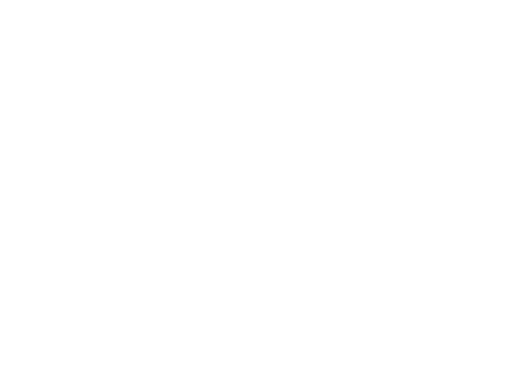

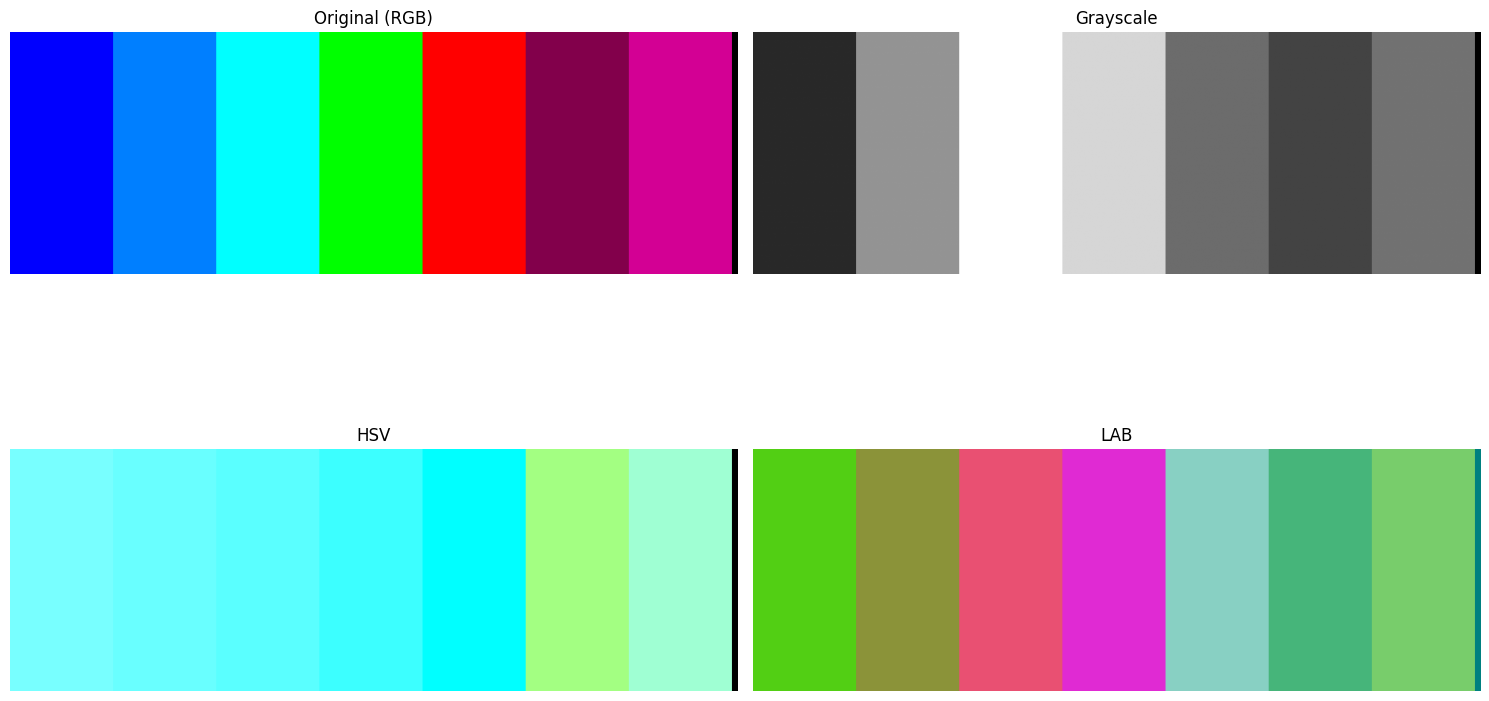

In [3]:
   # =============================================================================
# 📝 테스트 3: 색상 변환
# =============================================================================

def test3_color_conversion():
    """색상 변환 테스트"""
    print("\n🌈 테스트 3: 색상 변환")

    # 컬러 이미지 생성 (무지개 패턴)
    img = np.zeros((200, 600, 3), dtype=np.uint8)

    # 무지개 색상 만들기
    colors = [
        (255, 0, 0),    # 빨강
        (255, 127, 0),  # 주황
         (255, 255, 0),  # 노랑
        (0, 255, 0),    # 초록
        (0, 0, 255),    # 파랑
        (75, 0, 130),   # 남색
        (148, 0, 211)   # 보라
    ]

    # 각 색상을 세로 띠로 만들기
    strip_width = 600 // len(colors)
    for i, color in enumerate(colors):
        x_start = i * strip_width
        x_end = (i + 1) * strip_width
        img[:, x_start:x_end] = color
    plt.axis('off')
# 다양한 색공간으로 변환
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    # 결과 출력
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original (RGB)')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(gray, cmap='gray')
    plt.title('Grayscale')
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(hsv)
    plt.title('HSV')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(lab)
    plt.title('LAB')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# 함수 실행 코드 추가
if __name__ == "__main__":
    test3_color_conversion()


🔍 테스트 4: 이미지 필터링


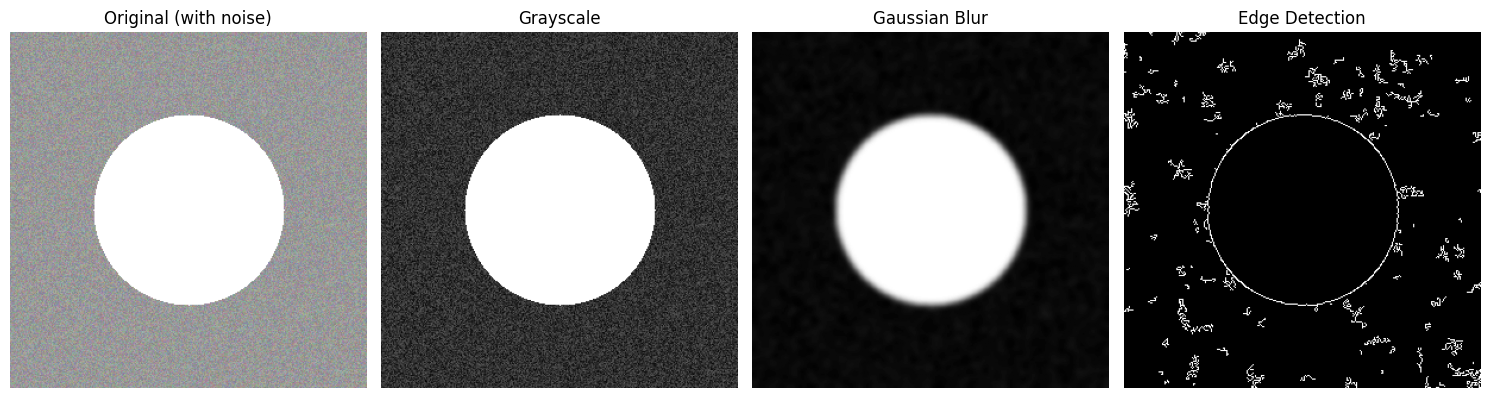

In [5]:
# =============================================================================
# 📝 테스트 4: 이미지 필터링 - 노이즈 처리, 블러링, 엣지 검출 시각화
# =============================================================================

def test4_image_filtering():
    """이미지 필터링 테스트"""
    print("\n🔍 테스트 4: 이미지 필터링")

    # ✅ 1. 노이즈가 포함된 이미지 생성
    img = np.ones((300, 300, 3), dtype=np.uint8) * 128  # 회색(128,128,128) 배경 생성 (300x300 RGB 이미지)

    # ✅ 2. 흰색 원 그리기 (중앙에 하이라이트된 객체 추가)
    cv2.circle(img, (150, 150), 80, (255, 255, 255), -1)  # 중심(150,150), 반지름 80, 색상 흰색, 채움(-1)

    # ✅ 3. 무작위 노이즈 추가
    noise = np.random.randint(0, 50, img.shape, dtype=np.uint8)  # 0~49 사이의 랜덤 값으로 노이즈 생성
    noisy_img = cv2.add(img, noise)  # 원본 이미지와 노이즈를 합성하여 노이즈 이미지 생성

    # ✅ 4. 그레이스케일(흑백) 변환
    gray = cv2.cvtColor(noisy_img, cv2.COLOR_BGR2GRAY)  # 필터링 및 엣지 처리 전에 채널 수 줄이기

    # ✅ 5. 가우시안 블러 필터 적용 (노이즈 완화 효과)
    blurred = cv2.GaussianBlur(gray, (15, 15), 0)  # 커널 크기 (15x15), 표준편차는 자동

    # ✅ 6. 엣지(경계) 검출 (Canny 알고리즘 사용)
    edges = cv2.Canny(gray, 50, 150)  # 하한 50, 상한 150의 임계값으로 엣지 검출

    # ✅ 7. 결과 시각화 (4분할 그래프 출력)
    plt.figure(figsize=(15, 5))  # 전체 그래프 사이즈 설정

    # ▶️ 1번: 노이즈 포함 원본 이미지 (컬러)
    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(noisy_img, cv2.COLOR_BGR2RGB))  # OpenCV는 BGR → RGB로 변환 필요
    plt.title('Original (with noise)')  # 제목
    plt.axis('off')  # 축 제거

    # ▶️ 2번: 흑백 이미지
    plt.subplot(1, 4, 2)
    plt.imshow(gray, cmap='gray')  # 그레이스케일로 표시
    plt.title('Grayscale')
    plt.axis('off')

    # ▶️ 3번: 가우시안 블러 처리 결과
    plt.subplot(1, 4, 3)
    plt.imshow(blurred, cmap='gray')
    plt.title('Gaussian Blur')
    plt.axis('off')

    # ▶️ 4번: 엣지(경계선) 검출 결과
    plt.subplot(1, 4, 4)
    plt.imshow(edges, cmap='gray')
    plt.title('Edge Detection')
    plt.axis('off')

    # 자동 여백 조절
    plt.tight_layout()
    plt.show()

# ✅ 테스트 함수 실행 (직접 실행할 경우만 실행되도록 설정)
if __name__ == "__main__":
    test4_image_filtering()



📁 테스트 5: 이미지 업로드 및 처리
이미지 파일을 업로드하세요...


Saving 표지판예시.jpg to 표지판예시 (2).jpg


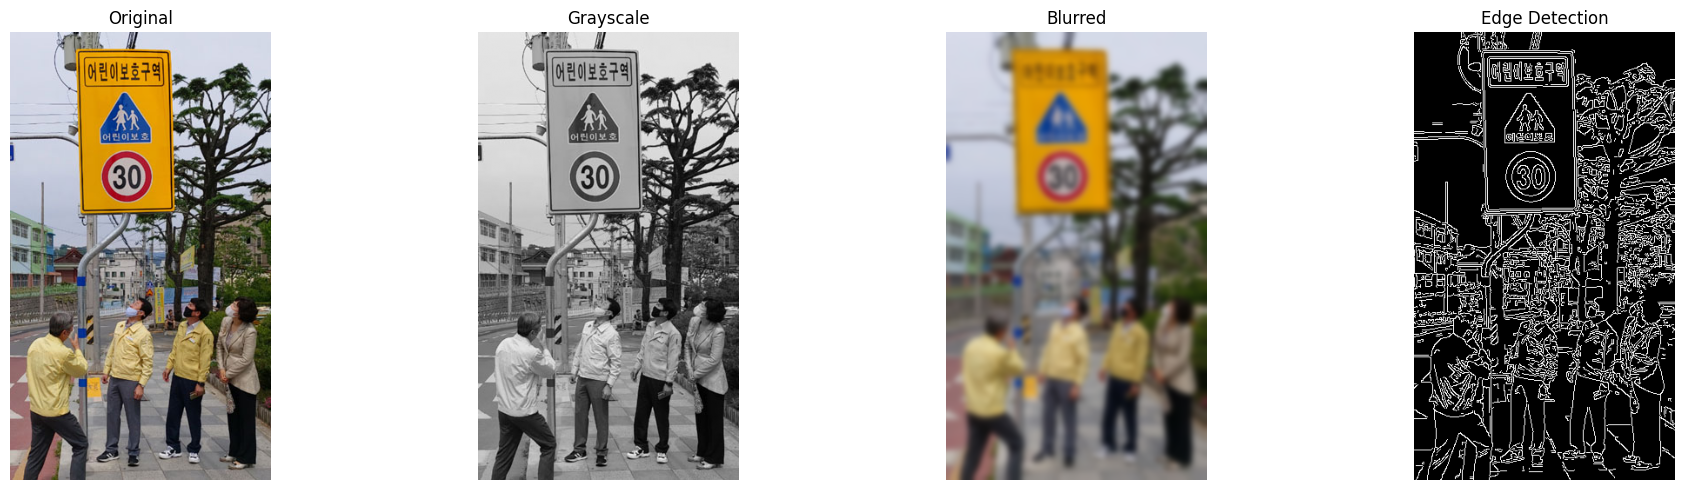

✅ 이미지 처리 완료! 크기: (515, 300, 3)


In [8]:
# =============================================================================
# 📝 테스트 5: 이미지 업로드 및 처리 (선택사항)
# =============================================================================

def test5_upload_and_process():
    """사용자가 업로드한 이미지를 OpenCV로 필터링하고 시각화하는 함수"""
    print("\n📁 테스트 5: 이미지 업로드 및 처리")
    print("이미지 파일을 업로드하세요...")

    try:
        # ✅ 1. Colab에서 이미지 파일 업로드 받기
        uploaded = files.upload()  # 파일 선택창 열림

        # ✅ 2. 업로드한 파일이 있으면 처리 시작
        if uploaded:
            filename = list(uploaded.keys())[0]  # 첫 번째 파일명 추출

            # ✅ 3. 이미지 데이터를 열기 (PIL 사용)
            image_data = uploaded[filename]
            img = Image.open(io.BytesIO(image_data))  # 바이너리 → 이미지 객체로 변환
            img_array = np.array(img)  # 이미지 객체를 NumPy 배열로 변환

            # ✅ 4. OpenCV 처리를 위해 RGB → BGR 변환 (OpenCV는 BGR 사용)
            if len(img_array.shape) == 3:
                img_bgr = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
            else:
                img_bgr = img_array  # 흑백 이미지일 경우 변환 생략

            # ✅ 5. 큰 이미지는 크기 축소 (너비가 800 이상인 경우)
            height, width = img_bgr.shape[:2]
            if width > 800:
                scale = 800 / width
                new_width = 800
                new_height = int(height * scale)
                img_bgr = cv2.resize(img_bgr, (new_width, new_height))  # 비율 유지하며 축소

            # ✅ 6. 다양한 이미지 처리 수행
            gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)  # 흑백 변환
            blurred = cv2.GaussianBlur(img_bgr, (21, 21), 0)  # 블러 처리 (컬러 기준)
            edges = cv2.Canny(gray, 100, 200)  # 엣지 검출 (흑백 기반)

            # ✅ 7. 결과 시각화 (4개의 이미지 비교)
            plt.figure(figsize=(20, 5))  # 전체 플롯 크기 설정

            # ▶️ 원본 이미지 (컬러)
            plt.subplot(1, 4, 1)
            plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))  # BGR → RGB 변환
            plt.title('Original')  # 제목
            plt.axis('off')

            # ▶️ 그레이스케일 이미지
            plt.subplot(1, 4, 2)
            plt.imshow(gray, cmap='gray')
            plt.title('Grayscale')
            plt.axis('off')

            # ▶️ 가우시안 블러 이미지 (컬러 유지)
            plt.subplot(1, 4, 3)
            plt.imshow(cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB))  # 다시 RGB 변환
            plt.title('Blurred')
            plt.axis('off')

            # ▶️ 엣지 검출 이미지
            plt.subplot(1, 4, 4)
            plt.imshow(edges, cmap='gray')
            plt.title('Edge Detection')
            plt.axis('off')

            # 자동 여백 조정 및 표시
            plt.tight_layout()
            plt.show()

            # ✅ 8. 처리 완료 메시지 출력
            print(f"✅ 이미지 처리 완료! 크기: {img_bgr.shape}")

    except Exception as e:
        # ✅ 예외 발생 시 사용자에게 알려주기
        print(f"❌ 업로드 중 오류: {e}")
        print("이 테스트는 건너뛰겠습니다.")

# ✅ 직접 실행할 때만 테스트 실행 (import 시 실행되지 않도록 보호)
if __name__ == "__main__":
    test5_upload_and_process()
